/var/folders/jj/9j0c_6196zx24tx5jb3ngnym0000gn/T/ipykernel_22337/1891428895.py:32: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(ticker, interval = interval, period = PERIOD)
[*********************100%***********************]  1 of 1 completed

Coefficient: [-0.00011819]
Intercept: 0.007871262126715526
R^2: 0.03051164140209439


Price,Close,High,Low,Open,Volume,diff(),diff().shift(1),Target,RSI
8173,627.031616,629.793916,626.602812,627.031616,63375000,1.186707,627.121338,0.000143,67.495310
8174,627.121338,627.988928,624.458737,627.360665,60046300,0.089722,632.456604,0.008508,67.587073
8175,632.456604,632.456604,627.988949,629.803924,70511000,5.335266,632.665955,0.000331,69.988460
8176,632.665955,634.391213,632.237151,632.845450,71307100,0.209351,635.338562,0.004224,65.265656
8177,635.338562,635.817276,633.084861,633.334170,56865400,2.672607,635.179016,-0.000251,79.574963
...,...,...,...,...,...,...,...,...,...
8254,683.380005,684.960022,680.950012,684.789978,62312500,0.380005,672.039978,-0.016594,60.107841
8255,672.039978,680.859985,670.520020,680.500000,103457800,-11.340027,671.929993,-0.000164,45.886617
8256,671.929993,675.659973,663.270020,665.380005,96846700,-0.109985,665.669983,-0.009316,37.998228
8257,665.669983,673.710022,662.169983,669.700012,90456100,-6.260010,660.080017,-0.008398,32.142289


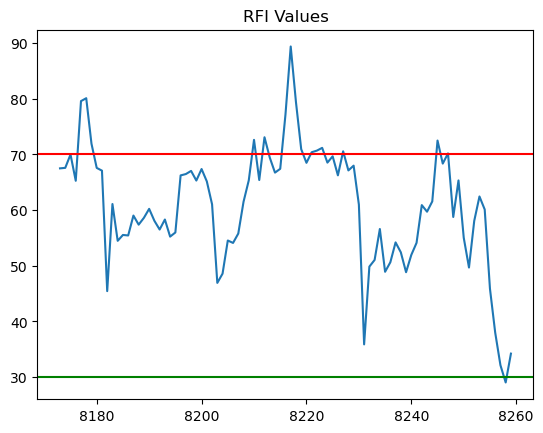

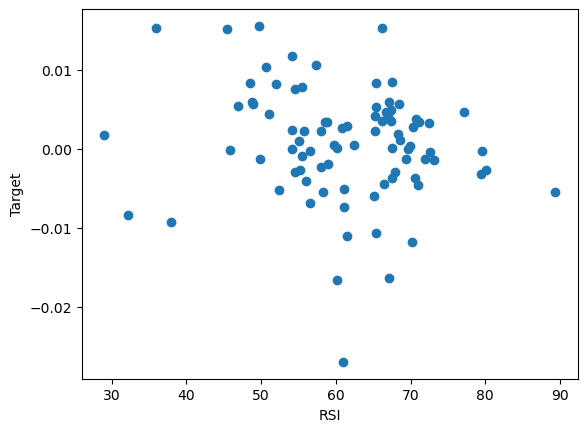

In [ ]:
import numpy as np 
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
import sklearn as sk

# Step 1: Ticker
TICKER = "SPY"

# Step 2: Price Behavior 
INTERVAL = "1d"
if INTERVAL == "1h":
    PERIOD = "730d"
else:
    PERIOD = "max"

# Step 3: RSI
RSI_LENGTH = 14
RSI_OVERBROUGHT = 70
RSI_OVERSOLD = 30

# Step 3: Price difference
SHIFT = 1
    # Tomorrow's Close Price in the same Row as today

# Step 5: Data Subsection
LOOKBACK = 100

def get_data(ticker = TICKER, interval = INTERVAL, lookback = LOOKBACK):

    # Step 1: Download Data
    df = yf.download(ticker, interval = interval, period = PERIOD)

    # Step 2: Select only Level 0 of Multilevel Columns
    df.columns = df.columns.get_level_values(0)

    # Step 3: Simplifying df for Plots
    df = df.reset_index(drop=True)

    return df.iloc[-lookback:, :]
        # -lookback: all loockback rows
        # : all columns 

# Defining y/the Dependent/the Target Variable
# --> We can create a strategy, that could forecast positively/negatively 
# with our Close Price changes 

# Lets inspect how a tech Indicator is related to how a price changes tomorrow
# For eg. RSI - you want to see a negative correlation between value of the RSI
# and Close Price Change the following day. Because the higher the value of RSI, 
# the more overbought the asset and shoudl decrease soon 
def add_target(df, shift = SHIFT):

    # Step 1: Test for difference
    df["diff()"] = df["Close"].diff()

    # Step 2: 
    df[f"diff().shift({shift})"] = df["Close"].shift(-shift)
    # diff(): Today's Price - Yesterday's Price == how much money you made or lost today
    # shift(-1): shift backwards in time. It takes the diff value from tomorrow into the row for today
    # We are trying to find a correlation with the price of tomorrow

    # Step 3: Finding Momentum. What is the difference between Close Price today and five days from now?
    # Abolute Price Changes: df["Target"] = df[f"diff().shift({shift})"] - df["Close"]
    # Percentage Price Changes:
    df["Target"] = (df[f"diff().shift({shift})"] - df["Close"])/df["Close"]

    return df

# Adding the Features/Independent Var: we want to create a Corelation between the Target and RSI 

def add_RSI(df, length = RSI_LENGTH, overbrought = RSI_OVERBROUGHT, oversold = RSI_OVERSOLD):
    
    # Step 1: Define Delta (Price changes between the Rows)
    price_change = df["Close"].diff()

    # Step 2: Group Price Changes based on Positive/Negative Returns
    gain = price_change.where(price_change > 0, 0)
    loss = -price_change.where(price_change < 0, 0)

    # Step 3: Calculate the Rolling Average for Length Days
    avg_gain = gain.rolling(window = length).mean()
    avg_loss = loss.rolling(window = length).mean()

    # Step 4: Calculate the Relative Strength
    rs = avg_gain / avg_loss
        # In percentage Terms: how much stronger have the Up Days been compared to the Down Days
        # rs = 3: avg_gain was 3x larger than the average loss --> Strong Upward Momentum
        # rs = 0.5: avg_gain was half the size of the average loss --> Strong Downward Momentum

    # Step 5: Calculate the RSI w/ Standardization (Values between 0-100)
    df["RSI"] = 100 - (100/(1+rs))

    # Step 6: Plot the RSI
    plt.figure()
    plt.plot(df["RSI"])
    plt.title("RFI Values")

    # Step 7: Plot horizontal lines for Overbrought/Oversold
    plt.axhline(overbrought, color="red") # Crossing Overbrought Line: triggers Short Signal
    plt.axhline(oversold, color="green") # Crossing Oversold Line: triggers Long Signal
    
    return df.dropna()

# Using our Scikit Library, to understand how our RSI is related to future price movements
# --> Looking for high R^2 Values

def generate_regression_output(df, features="RSI", target="Target"):

    # Step 1: Subset Data
    subset = df[[features,target]].dropna()
        # df[[x, y]]: Selects only the columns named x and y from df

    # Step 2: Reshape for Sklearn (convert data from Pandas Series/df format into NumPy array format)
    X = subset[[features]].values # 2d
        # Converts the feature column (x, e.g., 'RSI') into a NumPy array
        # [[x]]: selects the data as a DataFrame (even if it's just one column)
        # .values: extracts the data as a 2D NumPy array (e.g., [[80], [75], [70]]) - standard shape for features by sklearn
    y = subset[target].values #1d
        # [y]: selects the data as a Series
        # .values: extracts the data as a 1D NumPy array (e.g., [0.02, -0.01, 0.03]) - standard shape for the target by sklearn

    # Step 3: Model
    model = sk.linear_model.LinearRegression()
        # Creates a blank LR model object - to find the best straight line to describe the relationship between X and Y
    model.fit(X,y)
        # It feeds the model with X and Y, which adjusts the slope and y-intercept of the line, to minimizes the distance between its prediction and the true answer

    # Step 4: Use the Regression Model to predict the target variable 
    y_pred = model.predict(X)
        # It takes the trained model (the best-fit line) and feeds it your features
        # y_pred: generated array, contains the model's prediction for the target 

    # Step 5: Evaluating the relationship between Features and Target (r2 Score)
    r2 = sk.metrics.r2_score(y, y_pred)
        # r2: how much of the dependent variable (actual price change, y) is predictable from the features (RSI, x)
        # r2 (-1 to 1): when r2 close to 1.0 (or 100%), it explains why moving x is perfectly correlated with moving y

    # Step 6: coef, Intercept, r2...mse later on
    print(f"Coefficient: {model.coef_}")
    print(f"Intercept: {model.intercept_}")
    print(f"R^2: {r2}")
        # Printing the Formula: Y_predi = Intercept + (Coefficient * X)
        # Coefficient: slope of the line (strength and direction of the relationship) 
            # Here: -0.03, for every 1-unit increase in your feature (RSI), the model predicts the target (future price change) will decrease by $0.03
            # Too low to have a meaning
        # Intercept: It's the predicted target (y) if your feature (x) were equal to zero.

    # IMPORTANT NOTE (we will do later on):
        # Verify for Homoskedasticity, before runnin a Regression Analysis
        # We assumed that, in this case, but we will prove it by using percentage change later on

    # Step 7: To better understand it, lets build a Scatter Plot
    plt.figure()
    plt.title(f"The ")
    plt.scatter(X, y)
    plt.xlabel(f"{features}")
    plt.ylabel(f"{target}")
        # As we can see the results look flat and random, and we cant identify any direction 

    return df


def main():
    df = get_data()
    df = add_target(df)
    df = add_RSI(df)
    df = generate_regression_output(df)

    return df

df = main()
df

In [40]:
df.tail(10)

Price,Close,High,Low,Open,Volume,diff(),diff().shift(1),Target,RSI
8249,677.580017,680.859985,674.169983,674.979980,74402400,2.340027,670.309998,-0.010729,65.327525
8250,670.309998,677.380005,668.719971,676.469971,85035300,-7.270020,670.969971,0.000985,55.035704
8251,670.969971,671.080017,661.210022,667.909973,100592400,0.659973,681.440002,0.015604,49.685878
8252,681.440002,682.179993,675.030029,677.239990,75842900,10.470032,683.000000,0.002289,58.056839
8253,683.000000,683.570007,678.729980,679.950012,58953400,1.559998,683.380005,0.000556,62.446759
8254,683.380005,684.960022,680.950012,684.789978,62312500,0.380005,672.039978,-0.016594,60.107841
8255,672.039978,680.859985,670.520020,680.500000,103457800,-11.340027,671.929993,-0.000164,45.886617
8256,671.929993,675.659973,663.270020,665.380005,96846700,-0.109985,665.669983,-0.009316,37.998228
8257,665.669983,673.710022,662.169983,669.700012,90456100,-6.260010,660.080017,-0.008398,32.142289
8258,660.080017,665.119995,655.859985,662.099976,114293600,-5.589966,661.280029,0.001818,29.040705
